# MGC-X and DCorr-X: Independence Testing for Time Series

In this tutorial, we explore

- The theory behind the Cross Distance Correlation (DCorr-X) and Cross Multiscale Graph Correlation (MGC-X) tests
- The unique methodological features such as optimal scale and optimal lag
- The features of the implementation

## Theory

### Notation
Let $\mathbb{N}$ be the non-negative integers $\{0, 1, 2, ...\}$, and $\mathbb{R}$ be the real line $(-\infty, \infty)$. Let $F_X$, $F_Y$, and $F_{X,Y}$ represent the marginal and joint distributions of random variables $X$ and $Y$, whose realizations exist in $\mathcal{X}$ and $\mathcal{Y}$, respectively. Similarly, Let $F_{X_t}$, $F_{Y_s}$, and $F_{(X_t,Y_s)}$ represent the marginal and joint distributions of the time-indexed random variables $X_t$ and $Y_s$ at timesteps $t$ and $s$. For this work, assume $\mathcal{X} = \mathbb{R}^p$ and $\mathcal{Y} = \mathbb{R}^q$ for $p, q > 0$. Finally, let $\{(X_t,Y_t)\}_{t=-\infty}^{\infty}$ represent the full, jointly-sampled time series, structured as a countably long list of observations $(X_t, Y_t)$. 

### Problem Statement
The test addresses the problem of independence testing for time series. To formalize the problem, consider a strictly stationary time series $\{(X_t,Y_t)\}_{t=-\infty}^{\infty}$, with the observed sample $\{(X_1,Y_1),...,(X_n, Y_n)\}$. Choose some $M \in \mathbb{N}$, the `maximum_lag` hyperparameter. We test the independence of two series via the following hypothesis.

$$\begin{align*}
    H_0: F_{(X_t,Y_{t-j})} &= F_{X_t} F_{Y_{t-j}} \text{ for each } j \in \{0, 1, ..., M\}\\
    H_A: F_{(X_t,Y_{t-j})} &\neq F_{X_t} F_{Y_{t-j}} \text{ for some } j \in \{0, 1, ..., M\}
\end{align*}$$

The null hypothesis implies that for any $(M+1)$-length stretch in the time series, $X_t$ is pairwise independent of present and past values $Y_{t-j}$ spaced $j$ timesteps away (including $j=0$). A corresponding test for whether $Y_t$ is dependent on past values of $X_t$ is available by swapping the labels of each time series. Finally, the hyperparameter $M$ governs the maximum number of timesteps in the past for which we check the influence of $Y_{t-j}$ on $X_t$. This $M$ can be chosen for computation considerations, as well as for specific subject matter purposes, e.g. a signal from one region of the brain might only influence be able to influence another within 20 time steps implies $M = 20$. 

### The Test Statistic
Define the **cross-distance correlation** at lag $j$ as

$$\begin{align*}
    \text{DCorr}(j) := \text{DCorr}(X_t, Y_{t-j}).
\end{align*}$$

Where $\text{DCorr}(\cdot, \cdot)$ is the distance correlation function. Assuming strict stationarity of $\{(X_t,Y_t)\}$ is important in even defining $\text{DCorr}(j)$, as the parameter depends only on the spacing $j$, and not the timestep $t$ of $X_t$ and $Y_{t-j}$. Similarly, let $\text{DCorr}n(j)$ be its estimator, with $\text{MGC}_n(j)$ being the $\text{MGC}$ test statistic evaluated for $\{X_t\}$ and $\{Y_{t-j}\}$. The $\text{DCorr-X}^M$ test statistic is 

$$\begin{align*}
    \text{DCorr-X}_n^M &= \sum_{j=0}^{M} \left(\frac{n-j}{n}\right) \cdot \text{DCorr}n(j).
\end{align*}$$

Similarly, the $\text{MGC-X}$ test statistic is 

$$\begin{align*}
    \text{MGC-X}_n^M &= \sum_{j=0}^{M} \left(\frac{n-j}{n}\right) \cdot \text{MGC}_n(j).
\end{align*}$$

While $\text{MGC-X}$ is more computationally intensive than $\text{DCorr-X}$, $\text{MGC-X}$ employs multiscale analysis to achieve better finite-sample power in high-dimensional, nonlinear, and structured data settings [[1]](https://elifesciences.org/articles/41690).

### The P-Value
Let $T_n$ represent either of the test statistics above. To compute the p-value, one need to estimate the null distribution of $T_n$, namely its distribution under indepdendence pair of data. A typical permutation test would permute the indices $\{1,2,3,...,n\}$, reorder the series $\{Y_t\}$ according to this permutation, and $T_n$ would be computed on $\{X_t\}$ and the reordered $\{Y_t\}$. This procedure would be repeated $K$ times, generating $K$ samples of the test statistic under the null. This permutation test requires exchangeability of the sequence $\{Y_t\}$, which would be true in the i.i.d. case, but is generally violated in the time series case. Instead, a block permutation captures the dependence between elements of the series, as described in \cite{politis2003}. Letting $\lceil \cdot \rceil$ be the ceiling function, this procedure partitions the list of indices into size $b$ "blocks", and permutes the $\lceil \frac{n}{b} \rceil$ blocks in order to generate samples of the test statistic under the null.
Specifically,

1. Choose a random permutation of the indices $\{0, 1, 2, ..., \lceil \frac{n}{b} \rceil\}$. 

2. From index $i$ in the permutation, produce block $B_{i} = (Y_{bi+1},Y_{bi+2},...,Y_{bi + b})$, which is a section of the series $\{Y_t\}$.

3. Let the series $\{Y_{\pi(1)}, ..., Y_{\pi(n)}\} = (B_1, B_2, ..., B_{\frac{n}{b}})$, where $\pi$ maps indices $\{1,2,...,n\}$ to the new, block permuted indices.

4. Compute $T^{(r)}_n$ on the series $\{(X_t, Y_{\pi(t)})\}_{t=1}^n$ for replicate $r$.

Repeat this procedure $K$ times (typically $K = 100$ or $1000$), and let $T^{(0)}_n = T_n$, with:

$$\begin{align*}
    p\text{-value}(T_n) &= \frac{1}{K+1} \sum_{r=0}^K \mathbb{I}\{T^{(r)}_n \geq T_n\}
\end{align*}$$

where $\mathbb{I}\{\cdot\}$ is the indicator function.

## Using DCorr-X and MGC-X

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import pearsonr

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX

### Simulate time series
Let $\epsilon_t$ and $\eta_t$ be i.i.d. standard normally distributed.

Independent AR(1):
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    0.5 & 0\\
    0 & 0.5
    \end{bmatrix}
    \begin{bmatrix}
    X_{t-1}\\
    Y_{t-1}
    \end{bmatrix}
    +
    \begin{bmatrix}
    \epsilon_t\\
    \eta_t
    \end{bmatrix}$$

In [2]:
def indep_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are univarite AR(1) with phi = 0.5 for both series.
    # Noise follows N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = phi*X[t-1] + epsilons[t]
        Y[t] = phi*Y[t-1] + etas[t]
        
    return X, Y

Crosscorrelated AR(1):
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    0 & 0.5\\
    0.5 & 0
    \end{bmatrix}
    \begin{bmatrix}
    X_{t-1}\\
    Y_{t-1}
    \end{bmatrix}
    +
    \begin{bmatrix}
    \epsilon_t\\
    \eta_t
    \end{bmatrix}$$

In [3]:
def cross_corr_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]

    for t in range(1,n):
        X[t] = phi*Y[t-1] + epsilons[t]
        Y[t] = phi*X[t-1] + etas[t]
        
    return X, Y

Nonlinearly related at lag 1:
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    \epsilon_t Y_{t-1}\\
    \eta_t
    \end{bmatrix}$$

In [4]:
def nonlinear_lag1(n, phi = 1, sigma2 = 1):
    # X_t and Y_t are together a bivarite nonlinear process.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    Y[0] = etas[0]
 
    for t in range(1,n):
        X[t] = phi*epsilons[t]*Y[t-1]
        Y[t] = etas[t]
        
    return X, Y

### Plot time series

In [5]:
def plot_ts(X, Y, title, xlab = "X_t", ylab = "Y_t"):
    n = X.shape[0]
    t = range(1, n + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    fig.suptitle(title)
    plt.rcParams.update({'font.size': 15})
    
    ax1.plot(t, X)
    ax1.plot(t, Y)
    ax1.legend(['X_t', 'Y_t'], loc = 'upper left', prop={'size': 12})
    ax1.set_xlabel("t")
    
    ax2.scatter(X,Y, color="black") 
    ax2.set_ylabel(ylab)
    ax2.set_xlabel(xlab)

### Explore with DCorr-X and MGC-X.

In [6]:
def compute_dcorrx(X, Y, max_lag):
    dcorrx = DCorrX(max_lag = max_lag, which_test = 'unbiased')
    dcorrx_statistic, metadata = dcorrx.test_statistic(X, Y)
    p_value, _ = dcorrx.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("DCorrX test statistic:", dcorrx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)

def compute_mgcx(X, Y, max_lag):
    mgcx = MGCX(max_lag = max_lag)
    mgcx_statistic, metadata = mgcx.test_statistic(X, Y)
    p_value, _ = mgcx.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']
    optimal_scale = metadata['optimal_scale']
    
    print("MGCX test statistic:", mgcx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    print("Optimal Scale:", optimal_scale)

DCorrX test statistic: 0.0
P Value: 0.418
Optimal Lag: 0
MGCX test statistic: 0.0
P Value: 0.424
Optimal Lag: 0
Optimal Scale: [40, 40]


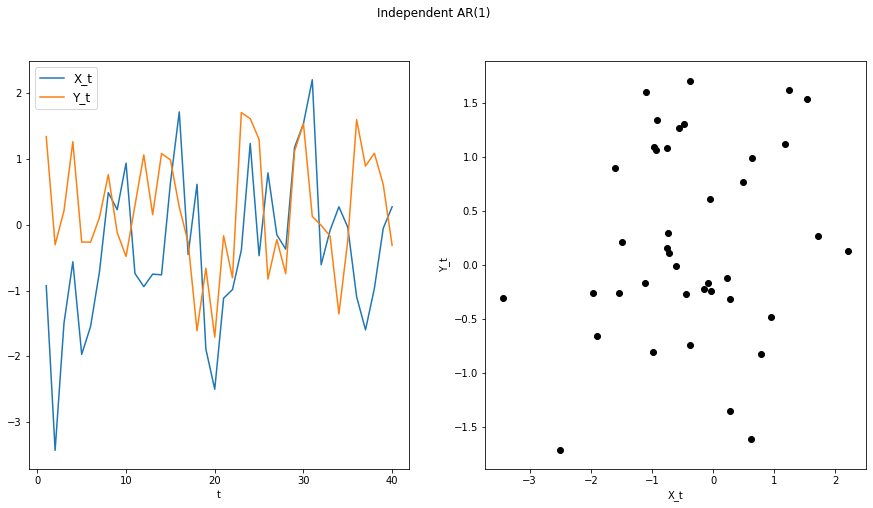

In [7]:
n = 40
max_lag = 0

X, Y = indep_ar1(n)
plot_ts(X, Y, "Independent AR(1)")
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag) 

In the crosscorrelated time series, the linear dependence will not be apparent at lag 0, but will be at lag 1.

DCorrX test statistic: 0.14380139143970183
P Value: 0.028
Optimal Lag: 0
MGCX test statistic: 0.14550875825340037
P Value: 0.069
Optimal Lag: 0
Optimal Scale: [40, 40]


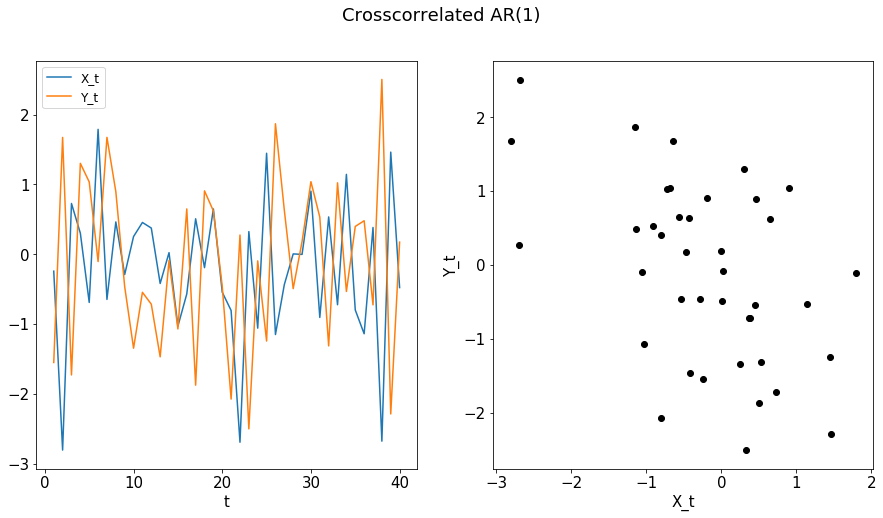

In [8]:
n = 40
max_lag = 0

X, Y = cross_corr_ar1(n)
plot_ts(X, Y, "Crosscorrelated AR(1)")
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

DCorrX test statistic: 0.35649077356316006
P Value: 0.003
Optimal Lag: 1
MGCX test statistic: 0.35511264701472667
P Value: 0.012
Optimal Lag: 1
Optimal Scale: [39, 39]


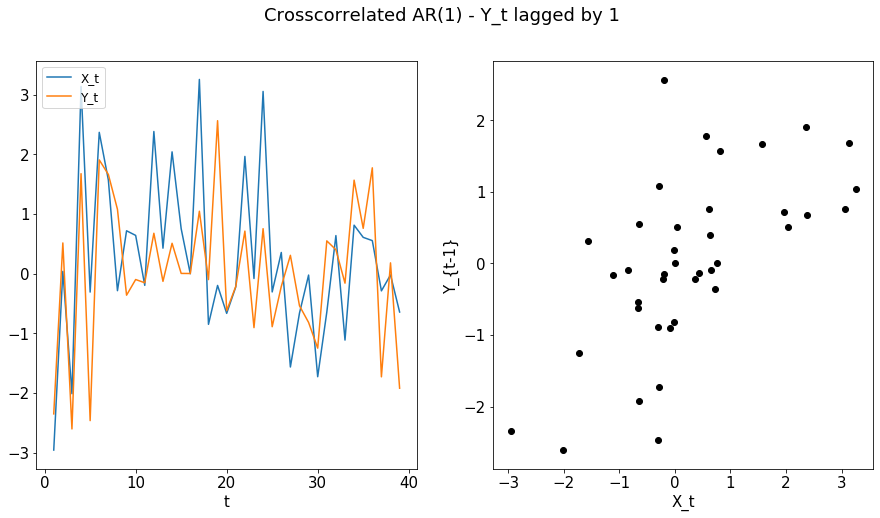

In [9]:
max_lag = 1

X, Y = cross_corr_ar1(n)
plot_ts(X[1:n], Y[0:(n-1)], "Crosscorrelated AR(1) - Y_t lagged by 1", ylab = "Y_{t-1}")
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

The final example is a nonlinearly related series, for which the Pearson's correlation may be insufficient.

In [10]:
X, Y = nonlinear_lag1(n)

print("Pearson's Correlation at lag 0: " + str(pearsonr(X,Y)[0]))
print("Pearson's Correlation at lag 1: " + str(pearsonr(X[1:n],Y[0:(n-1)])[0]))

Pearson's Correlation at lag 0: -0.16740183702829184
Pearson's Correlation at lag 1: 0.2840269513248397


DCorrX test statistic: 0.07967130243446058
P Value: 0.159
Optimal Lag: 1
MGCX test statistic: 0.35820807204909766
P Value: 0.008
Optimal Lag: 0
Optimal Scale: [35, 13]


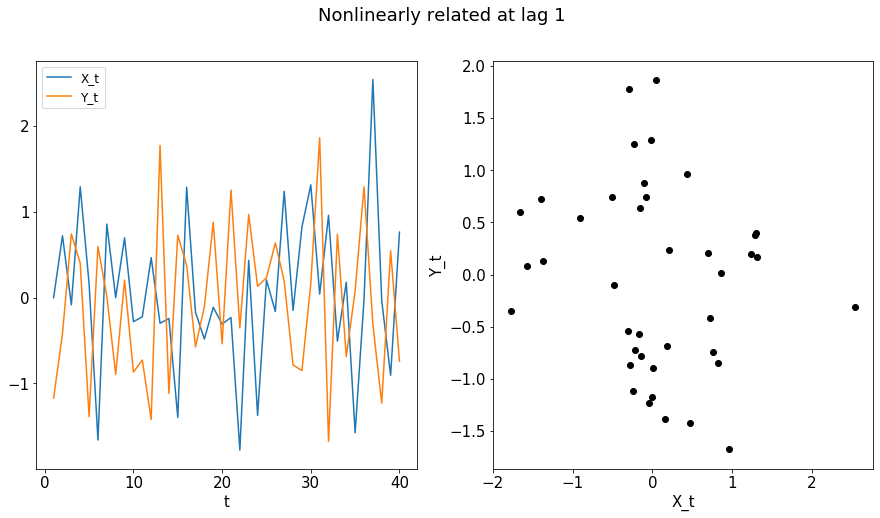

In [11]:
plot_ts(X, Y, "Nonlinearly related at lag 1")
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

### Understanding the Optimal Lag
The optimal lag allows the user to understand better the temporal nature of the relationship between $X_t$ and $Y_t$. The polt below shows the empirical distribution of the optimal lag estimate for $\text{MGC-X}$ as $n$ increases.

In [12]:
# Plot the distribution of optimal lag estimates.
def opt_lag_dist(optimal_lags_dcorrx, optimal_lags_mgcx, n, M = 10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5), sharey = True)
    plt.rcParams.update({'font.size': 15})
    
    ax1.set_xlabel('Lag j')
    ax1.set_title("DCorr-X, n = %d" % n)
    ax2.set_xlabel('Lag j')
    ax2.set_title("MGC-X, n = %d" % n)
    ax1.set_ylabel("Freq. of Optimal Lag Estimates")
    
    # Optimal lag predictions.
    weights = np.ones_like(optimal_lags_dcorrx)/float(len(optimal_lags_dcorrx))
    ax1.hist(optimal_lags_dcorrx, 
             bins = np.arange(M)-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = 'blue')
    weights = np.ones_like(optimal_lags_mgcx)/float(len(optimal_lags_mgcx))
    ax2.hist(optimal_lags_mgcx, 
             bins = np.arange(M)-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = 'red')
    
    plt.show()

We simulate a nonlinear process that has clear dependence at lag 3.
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    \epsilon_t Y_{t-3}\\
    \eta_t
    \end{bmatrix}$$

In [13]:
def nonlinear_lag3(n, phi = 1, sigma2 = 1):
    # X_t and Y_t are together a bivarite nonlinear process.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    for t in range(3):
        Y[t] = etas[t]
 
    for t in range(3,n):
        X[t] = phi*epsilons[t]*Y[t-3]
        Y[t] = etas[t]
        
    return X, Y

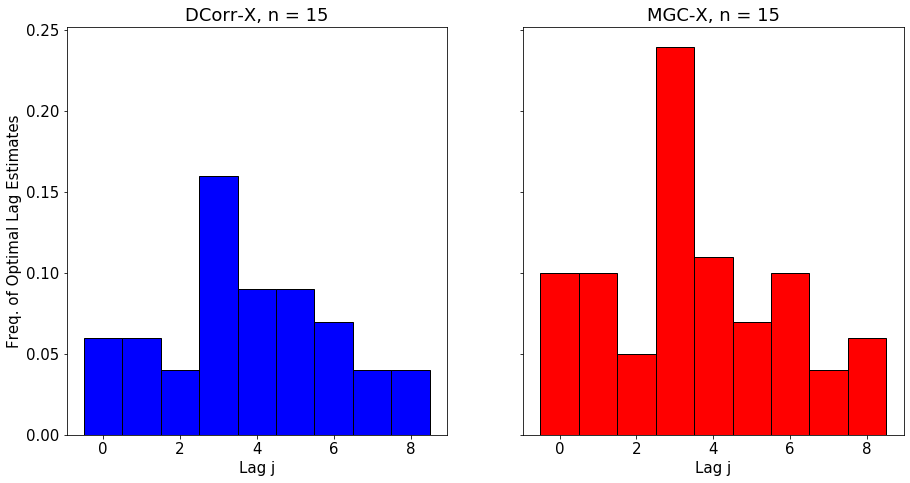

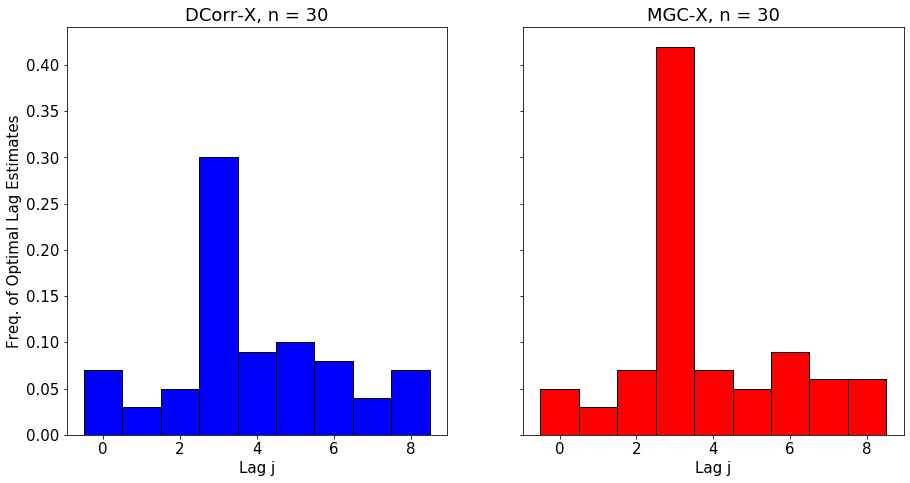

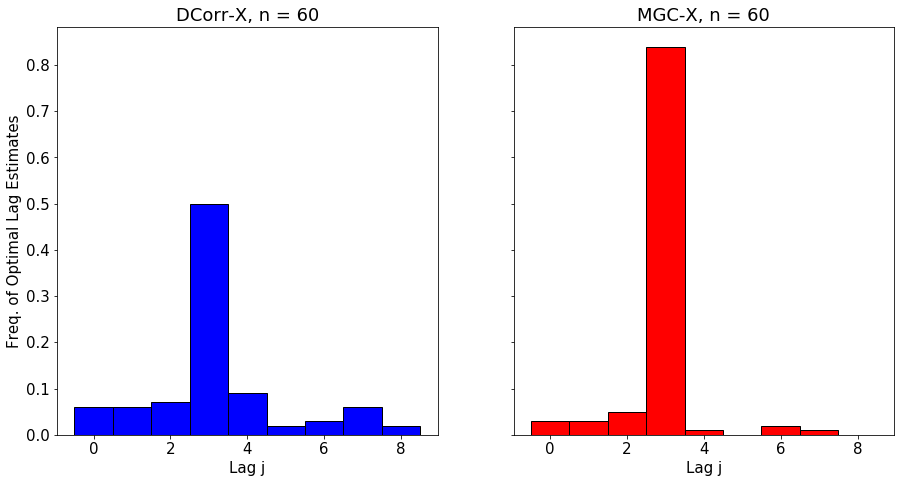

In [14]:
M = 10
num_sims = 100

dcorrx = DCorrX(max_lag = M)
mgcx = MGCX(max_lag = M)
optimal_lags_dcorrx = np.zeros(num_sims)
optimal_lags_mgcx = np.zeros(num_sims)

# Run experiments.
for n in [15, 30, 60]:
    for t in range(num_sims):
        X, Y = nonlinear_lag3(n)
        test_statistic, metadata = dcorrx.test_statistic(X, Y)
        optimal_lags_dcorrx[t] = metadata['optimal_lag']
        test_statistic, metadata = mgcx.test_statistic(X, Y)
        optimal_lags_mgcx[t] = metadata['optimal_lag']
    opt_lag_dist(optimal_lags_dcorrx, optimal_lags_mgcx, n)

`DCorrX` and `MGCX` both close in on the correct lag as `n` increases, with `MGCX` having higher accuracy due to advantages in nonlinear settings.